# **Forecasting Temperature with Outliers Imputation**

**Main goal of the project:** 
>***Forecasting temperature in a accurate way using a Machine Learning general approach.***

  This part of the project will be focused in the following forecasting approaches: 

  - Forecasting with outliers imputation.

For each approach the best model will be found, applying ML evaluation techniques like cross Validation and hyper-parameter optimization.

**Author:** ***Fabio Scielzo Ortiz***

### **Requirements**

In [1]:
import polars as pl 
import pandas as pd 
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import timedelta
from sklearn.metrics import mean_absolute_error
import datetime
import warnings
warnings.filterwarnings("ignore")
import optuna
from PIL import Image
import pickle
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg 
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.ForecasterAutoregMultiVariate import ForecasterAutoregMultiVariate
from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import ElasticNet

In [2]:
sys.path.insert(0, r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series')
from PyTS import MakeLags, SARIMA, SimpleExpSmooth, VAR, LinearRegressionTS, KNeighborsRegressorTS, wape, absolute_r2, train_test_split_time_series, OptunaSearchTSCV, time_series_multi_plot, get_prediction_dates, predictive_time_series_plot, KFold_split_time_series, KFold_score_time_series, KFold_time_series_plot, autoSARIMA, DecisionTreeRegressorTS, ExtraTreesRegressorTS, RandomForestRegressorTS, HistGradientBoostingRegressorTS,  MLPRegressorTS, LinearSVRTS, XGBRegressorTS, RidgeTS, LassoTS, ElasticNetTS, StackingRegressorTS, BaggingRegressorTS, OutliersImputer, outliers_time_series_plot

In [3]:
sys.path.insert(0, 'C:/Users/fscielzo/Documents/DataScience-GitHub/EDA')
from EDA import prop_cols_nulls

### **Data**

#### **Conceptual description**

Jena Climate is weather time series dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

This dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

The dataset can be found in `Kaggle`: https://www.kaggle.com/datasets/mnassrib/jena-climate

| Variable Name | Description | Type |
|----------|----------|----------|
| `Date Time`    |Date-time reference | Date   |
| `p (mbar)`    | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.  | quantitative  |
| `T (degC)`   |  Temperature in Celsius  |  quantitative  |
|  `Tpot (K)`   |  Temperature in Kelvin  |  quantitative  |
| `Tdew (degC)` |   Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.  |  quantitative  |
| `rh (%)`   |  Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.  | quantitative  |
|  `VPmax (mbar)`  |  Saturation vapor pressure | quantitative  |
|  `VPact (mbar)`   |  Vapor pressure   |  quantitative  |
| `	VPdef (mbar)`   | Vapor pressure deficit   | quantitative   |
|  `sh (g/kg)`  |  Specific humidity | quantitative  |
|   `H2OC (mmol/mol)`      | Water vapor concentration   | quantitative  |
| `rho (g/m ** 3)`   | Airtight | quantitative   |
| `wv (m/s)`   |  Wind speed  |  quantitative  |
| `max. wv (m/s)`  |  Maximum wind speed |  quantitative  |
|  `wd (deg)`  |  Wind direction in degrees  |  quantitative  |


#### **Preprocessing the data**

The next piece of code read the data, rename their columns, change the date column to an appropriate date format, ad columns with the day, week, month, quarter and year of each observation and remove the last row which is the only point related with 2017.

In [4]:
climate_df = pl.read_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_2009_2016.csv')

climate_df.columns = ['date', 'p', 'T', 'Tpot', 'Tdew', 'rh', 'VPmax', 'VPact', 'VPdef', 
                      'sh', 'H2OC', 'rho', 'wv', 'max_wv', 'wd']

climate_df = climate_df.with_columns(pl.col("date").str.to_date("%d.%m.%Y %H:%M:%S").name.keep())

climate_df = climate_df.with_columns(climate_df['date'].dt.day().alias('day'),
                        climate_df['date'].dt.month().alias('month'),
                        climate_df['date'].dt.year().alias('year'),
                        climate_df['date'].dt.week().alias('week'),
                        climate_df['date'].dt.quarter().alias('quarter'))

climate_df = climate_df[:-1,:] # removing last row, just because is the only data point regarding 2017

The data has 420550 rows and 20 columns.

In [5]:
climate_df.shape

(420550, 20)

We print a head and tail of the data.

In [6]:
climate_df.head()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1,1,2009,1,1
2009-01-01,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1,1,1,2009,1,1
2009-01-01,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6,1,1,2009,1,1
2009-01-01,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0,1,1,2009,1,1
2009-01-01,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3,1,1,2009,1,1


In [7]:
climate_df.tail()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2016-12-31,1000.11,-3.93,269.23,-8.09,72.6,4.56,3.31,1.25,2.06,3.31,1292.41,0.56,1.0,202.6,31,12,2016,52,4
2016-12-31,1000.07,-4.05,269.1,-8.13,73.1,4.52,3.3,1.22,2.06,3.3,1292.98,0.67,1.52,240.0,31,12,2016,52,4
2016-12-31,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,31,12,2016,52,4
2016-12-31,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.0,215.2,31,12,2016,52,4
2016-12-31,999.81,-4.23,268.94,-8.53,71.8,4.46,3.2,1.26,1.99,3.2,1293.56,1.49,2.16,225.8,31,12,2016,52,4


We make a fast descriptive summary of the data.

In [8]:
climate_df.describe()

describe,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""420550""",420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0,420550.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,989.212751,9.450181,283.492779,4.955886,76.00826,13.576273,9.533771,4.042419,6.022418,9.640238,1216.062557,1.702225,3.056558,174.743714,15.713359,6.51732,2012.496802,26.617729,2.506375
"""std""",null,8.358475,8.423346,8.504449,6.730651,16.476195,7.739016,4.184158,4.896855,2.656135,4.235388,39.975064,65.446792,69.017014,86.681794,8.799074,3.448315,2.289752,15.060659,1.116766
"""min""","""2009-01-01""",913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,-9999.0,-9999.0,0.0,1.0,1.0,2009.0,1.0,1.0
"""25%""",null,984.2,3.36,277.43,0.24,65.21,7.78,6.21,0.87,3.92,6.29,1187.49,0.99,1.76,124.9,8.0,4.0,2010.0,14.0,2.0
"""50%""",null,989.58,9.42,283.47,5.22,79.3,11.82,8.86,2.19,5.59,8.96,1213.79,1.76,2.96,198.1,16.0,7.0,2012.0,27.0,3.0
"""75%""",null,994.72,15.47,289.53,10.07,89.4,17.6,12.35,5.3,7.8,12.49,1242.77,2.86,4.74,234.1,23.0,10.0,2014.0,40.0,4.0
"""max""","""2016-12-31""",1015.35,37.28,311.34,23.11,100.0,63.77,28.32,46.01,18.13,28.82,1393.54,28.49,23.5,360.0,31.0,12.0,2016.0,53.0,4.0


There is an anomaly in the variable `wv`, since the minimum value of it is -9999 when it should be a positive variable since is measure in m/s. We are going to clean this anomaly (error) substituting this value by the mean of the variable.

Naturally, this anomaly has been transmitted to `max_wv`, so, we will clean this variable as well.

In [9]:
climate_df = climate_df.with_columns(
                        pl.when(pl.col('wv') == pl.col('wv').min())
                        .then(pl.col('wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('wv'))  # Keeps original value when condition is False
                        .alias('wv')  # Rename the resulting column back to 'variable'
                    )

climate_df = climate_df.with_columns(
                        pl.when(pl.col('max_wv') == pl.col('max_wv').min())
                        .then(pl.col('max_wv').mean())  # The replacement value for when the condition is True
                        .otherwise(pl.col('max_wv'))  # Keeps original value when condition is False
                        .alias('max_wv')  # Rename the resulting column back to 'variable'
                    )

In [10]:
# climate_df.write_csv(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\Data\jena_climate_cleaned.csv')

Checking if the last transformation has solved the anomaly completely.

In [11]:
climate_df.min()

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i8,i8,i32,i8,i8
2009-01-01,913.6,-23.01,250.6,-25.01,12.95,0.95,0.79,0.0,0.5,0.8,1059.45,0.0,0.0,0.0,1,1,2009,1,1


Checking if there are missing values.

In [12]:
prop_cols_nulls(climate_df)

date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max_wv,wd,day,month,year,week,quarter
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see that there are non missing values in the data, which is specially important.

In [13]:
''''
# If the data would have missing values, a way to fill them could be this:

climate_df = climate_df.fill_null(strategy="forward") # fill NaN's with the previous values 
climate_df = climate_df.fill_null(strategy="backward") # fill NaN's with the later values 
'''

'\'\n# If the data would have missing values, a way to fill them could be this:\n\nclimate_df = climate_df.fill_null(strategy="forward") # fill NaN\'s with the previous values \nclimate_df = climate_df.fill_null(strategy="backward") # fill NaN\'s with the later values \n'

### **Daily time series**

In this section we are going to compute the daily time series for the series with which we are going to work.

In [14]:
df = {}
variables_forecasting = ['T', 'rh', 'VPact', 'H2OC', 'wv', 'max_wv', 'wd', 'p']
for col in variables_forecasting:
    df[col] = climate_df.group_by(['year', 'month', 'day']).agg(pl.col(col).mean()).sort(['year', 'month', 'day'])
    df[col] = df[col].with_columns((pl.col("day").cast(str) + '-' + pl.col("month").cast(str) + '-' + pl.col("year").cast(str)).alias("date"))
    df[col] = df[col].with_columns(pl.col("date").str.to_date("%d-%m-%Y").name.keep())

In [15]:
for col in variables_forecasting:
    print('--------------------------------------')
    print(f'head-tail of {col}')

    display(df[col].head(3))
    display(df[col].tail(3))

--------------------------------------
head-tail of T


year,month,day,T,date
i32,i8,i8,f64,date
2009,1,1,-6.810629,2009-01-01
2009,1,2,-3.728194,2009-01-02
2009,1,3,-5.271736,2009-01-03


year,month,day,T,date
i32,i8,i8,f64,date
2016,12,29,2.67625,2016-12-29
2016,12,30,-1.706597,2016-12-30
2016,12,31,-2.4925,2016-12-31


--------------------------------------
head-tail of rh


year,month,day,rh,date
i32,i8,i8,f64,date
2009,1,1,91.086014,2009-01-01
2009,1,2,92.086806,2009-01-02
2009,1,3,76.458056,2009-01-03


year,month,day,rh,date
i32,i8,i8,f64,date
2016,12,29,90.384722,2016-12-29
2016,12,30,92.927083,2016-12-30
2016,12,31,74.360694,2016-12-31


--------------------------------------
head-tail of VPact


year,month,day,VPact,date
i32,i8,i8,f64,date
2009,1,1,3.355524,2009-01-01
2009,1,2,4.267292,2009-01-02
2009,1,3,3.107708,2009-01-03


year,month,day,VPact,date
i32,i8,i8,f64,date
2016,12,29,6.705833,2016-12-29
2016,12,30,5.048542,2016-12-30
2016,12,31,3.765069,2016-12-31


--------------------------------------
head-tail of H2OC


year,month,day,H2OC,date
i32,i8,i8,f64,date
2009,1,1,3.357832,2009-01-01
2009,1,2,4.26875,2009-01-02
2009,1,3,3.111944,2009-01-03


year,month,day,H2OC,date
i32,i8,i8,f64,date
2016,12,29,6.613542,2016-12-29
2016,12,30,4.996875,2016-12-30
2016,12,31,3.749444,2016-12-31


--------------------------------------
head-tail of wv


year,month,day,wv,date
i32,i8,i8,f64,date
2009,1,1,0.778601,2009-01-01
2009,1,2,1.419514,2009-01-02
2009,1,3,1.250903,2009-01-03


year,month,day,wv,date
i32,i8,i8,f64,date
2016,12,29,0.837986,2016-12-29
2016,12,30,1.138125,2016-12-30
2016,12,31,0.803403,2016-12-31


--------------------------------------
head-tail of max_wv


year,month,day,max_wv,date
i32,i8,i8,f64,date
2009,1,1,1.378252,2009-01-01
2009,1,2,2.227361,2009-01-02
2009,1,3,2.065069,2009-01-03


year,month,day,max_wv,date
i32,i8,i8,f64,date
2016,12,29,1.394028,2016-12-29
2016,12,30,1.839306,2016-12-30
2016,12,31,1.453542,2016-12-31


--------------------------------------
head-tail of wd


year,month,day,wd,date
i32,i8,i8,f64,date
2009,1,1,181.863077,2009-01-01
2009,1,2,125.072014,2009-01-02
2009,1,3,190.383333,2009-01-03


year,month,day,wd,date
i32,i8,i8,f64,date
2016,12,29,196.642639,2016-12-29
2016,12,30,201.359028,2016-12-30
2016,12,31,194.592153,2016-12-31


--------------------------------------
head-tail of p


year,month,day,p,date
i32,i8,i8,f64,date
2009,1,1,999.145594,2009-01-01
2009,1,2,999.600625,2009-01-02
2009,1,3,998.548611,2009-01-03


year,month,day,p,date
i32,i8,i8,f64,date
2016,12,29,1013.957569,2016-12-29
2016,12,30,1010.460278,2016-12-30
2016,12,31,1004.476181,2016-12-31


Now we build a data frame with each one of the daily time series (just the values, not th dates).

In [16]:
df_multi = pl.concat([pl.DataFrame(df[col][col]) for col in variables_forecasting], how='horizontal')
df_multi

T,rh,VPact,H2OC,wv,max_wv,wd,p
f64,f64,f64,f64,f64,f64,f64,f64
-6.810629,91.086014,3.355524,3.357832,0.778601,1.378252,181.863077,999.145594
-3.728194,92.086806,4.267292,4.26875,1.419514,2.227361,125.072014,999.600625
-5.271736,76.458056,3.107708,3.111944,1.250903,2.065069,190.383333,998.548611
-1.375208,89.417361,4.938958,4.997014,1.720417,3.564861,213.069861,988.510694
-4.867153,86.260417,3.806736,3.847778,3.800278,5.94,118.287361,990.405694
-15.482847,83.774722,1.5425,1.547083,1.226806,2.097708,156.915486,997.052986
-15.734375,85.659722,1.720972,1.731458,0.7225,1.483333,161.920486,993.506389
-9.609167,87.582639,2.601181,2.593542,0.870208,1.443611,182.944444,1002.969653
-12.301458,83.97625,2.019653,2.013819,0.663819,1.237778,166.947917,1003.113333


#### **Plotting**

In this section we are going to plot all the considered time series as a multi-plot.

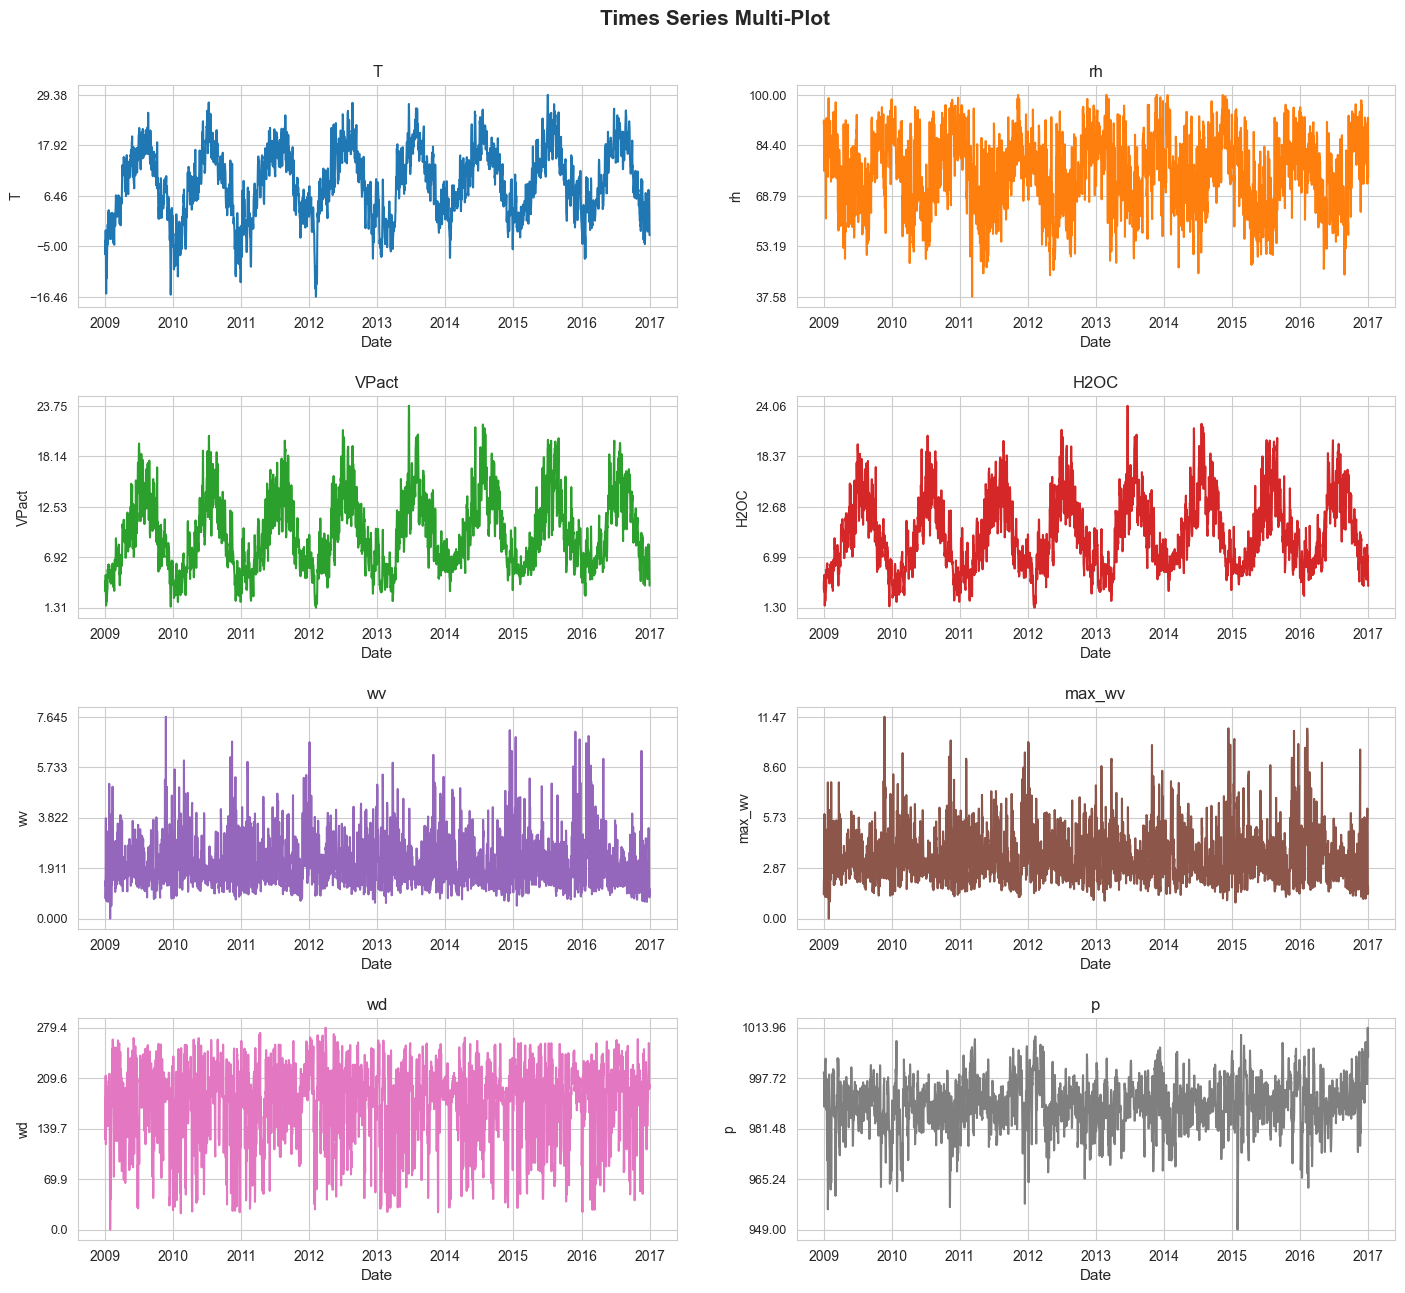

In [17]:
time_series_multi_plot(df=df, n_cols=2, figsize=(17, 15), title='Times Series Multi-Plot', 
                       titles_size=15, title_height=0.93, 
                       subtitles_size=12, hspace=0.4, wspace=0.2)

### **Outlier detection and imputation**

`PyTS` incorporates tools for outliers detection and imputation in Time Series.

The idea of this methods is to detect extreme values in a given series (using the Tukey rule so far), and substitute (impute) them by mean of different strategies.

The current strategies available for imputing the outliers are: 

- Trend: the outliers are imputed using the trend of the original series.

- Model: the outliers are imputed using the estimations of a given model for those points. 

The main goals of this section are:

- Illustrates how the outlier detection and imputation methods work visually.

- Try outliers imputations as another alternative for forecasting the temperature in Jena 15 days ahead.

    - Basically, we are going to follow the schema of the  above sections but applying outliers imputations as a first step in the pipeline. 
    
    - We want to investigate if this preprocessing step could improve the predictive performance of some models.

#### **Visualization**

In [18]:
Y, X_st, = {}, {}
X_sk, Y_sk, = {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}
# Defining a grid of lags to be considered as hyper-parameters
lags_grid = [5, 10, 15, 20, 30, 40, 50]

############################################################################
# For univariate forecasting
############################################################################

for col in variables_forecasting:
    # Original series 
    Y[col] = df[col][col].to_numpy()
    # Fake X for statsmodels based implementations
    X_st[col] = np.zeros((len(Y[col]), 4))
                            
    # Lagged X and Y for sklearn based implementations
    for lag in lags_grid:
        make_lags = MakeLags(n_lags=lag, ascending=True)
        make_lags.fit()
        X_sk[col][lag], Y_sk[col][lag] = make_lags.transform(y=Y[col])

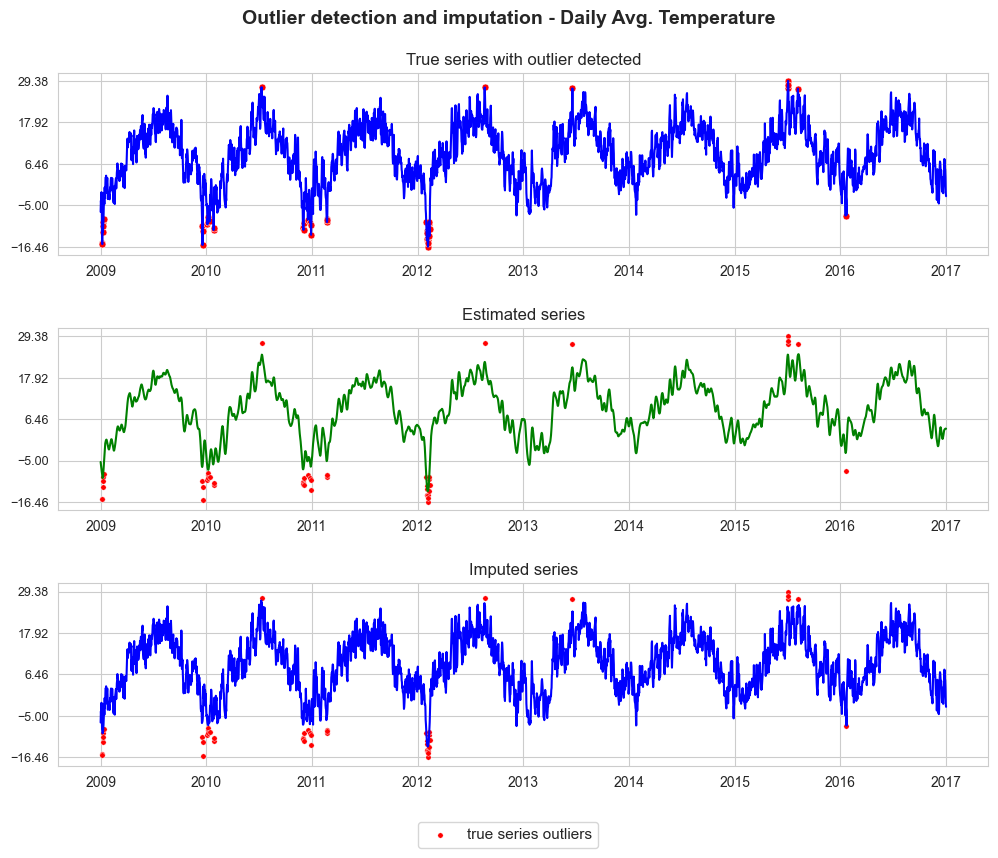

In [20]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='trend', period=7, h=1),
                          y=Y['T'], dates=df['T']['date'], 
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          legend_size=11)

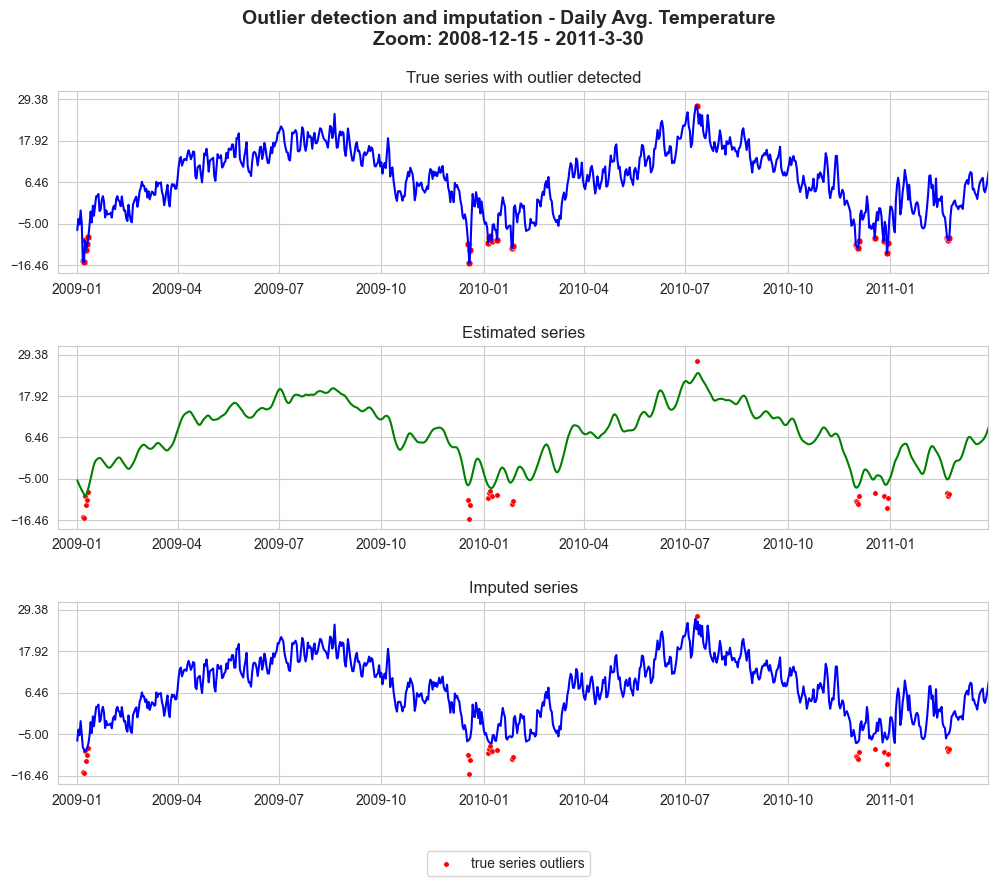

In [21]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='trend', period=7, h=1),
                          y=Y['T'], dates=df['T']['date'], 
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0),
                          zoom_start_date='2008-12-15', zoom_end_date='2011-3-30', title_height=0.97)

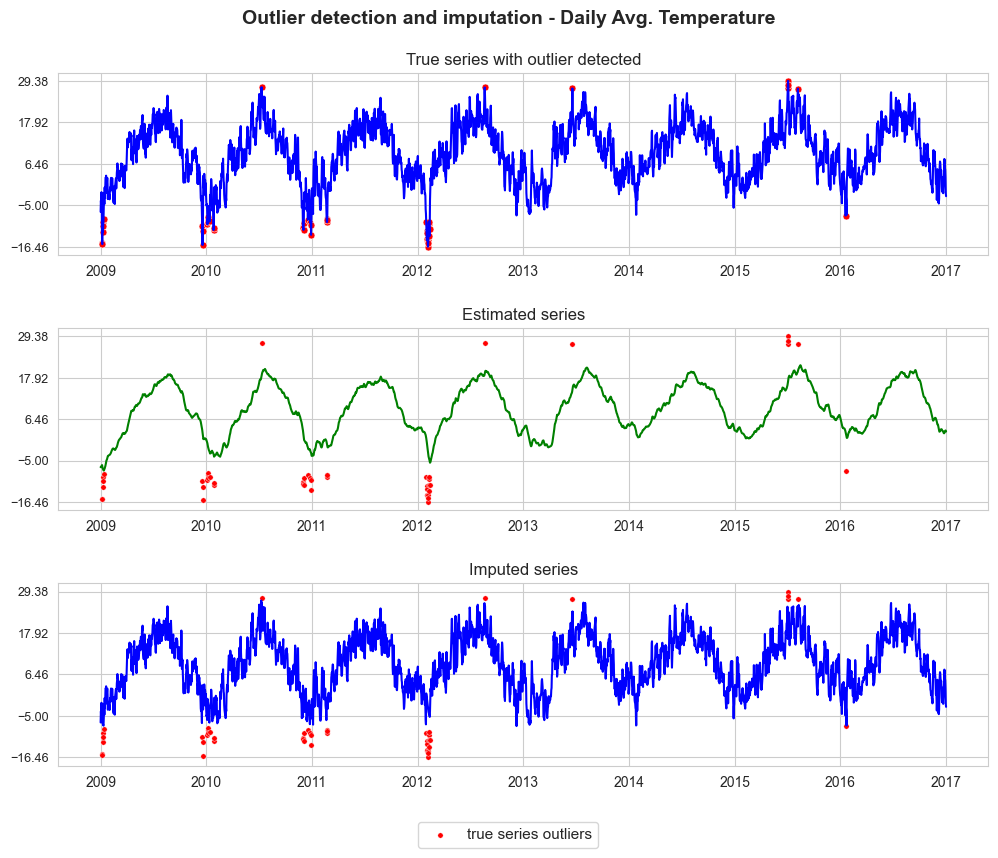

In [23]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='model', estimator=SimpleExpSmooth(smoothing_level=0.05), h=1),
                          y=Y['T'], dates=df['T']['date'], X=X_st['T'],
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          legend_size=11)

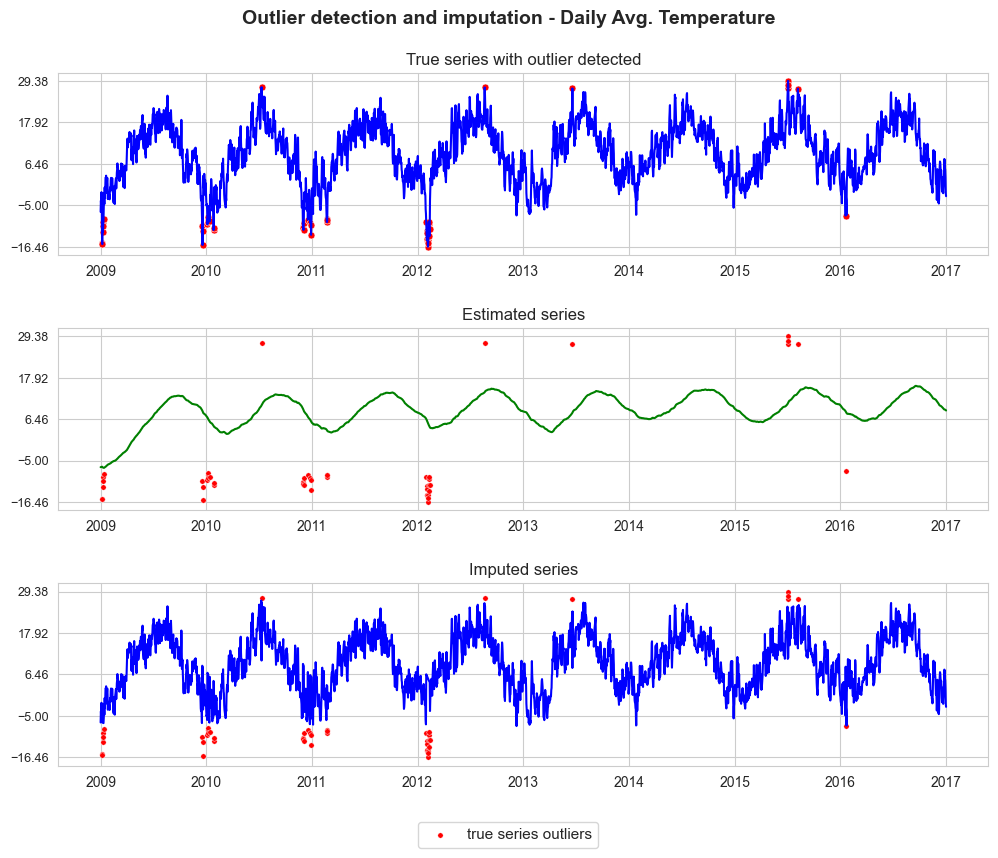

In [116]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='model', estimator=SimpleExpSmooth(smoothing_level=0.01), h=1),
                          y=Y['T'], dates=df['T']['date'], X=X_st['T'],
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          legend_size=11)

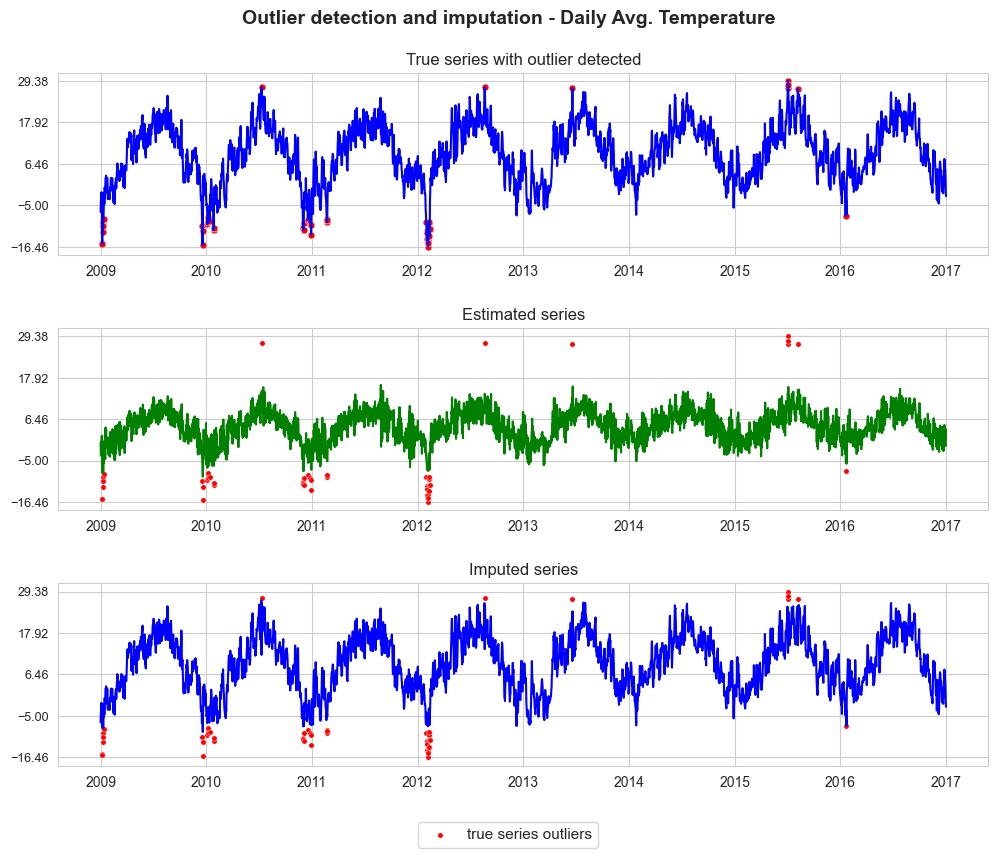

In [25]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='model', 
                                                           estimator=SARIMA(p=0, d=0, q=1, P=0, D=0, Q=0, s=0), h=1),
                          y=Y['T'], dates=df['T']['date'], X=X_st['T'],
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          legend_size=11)

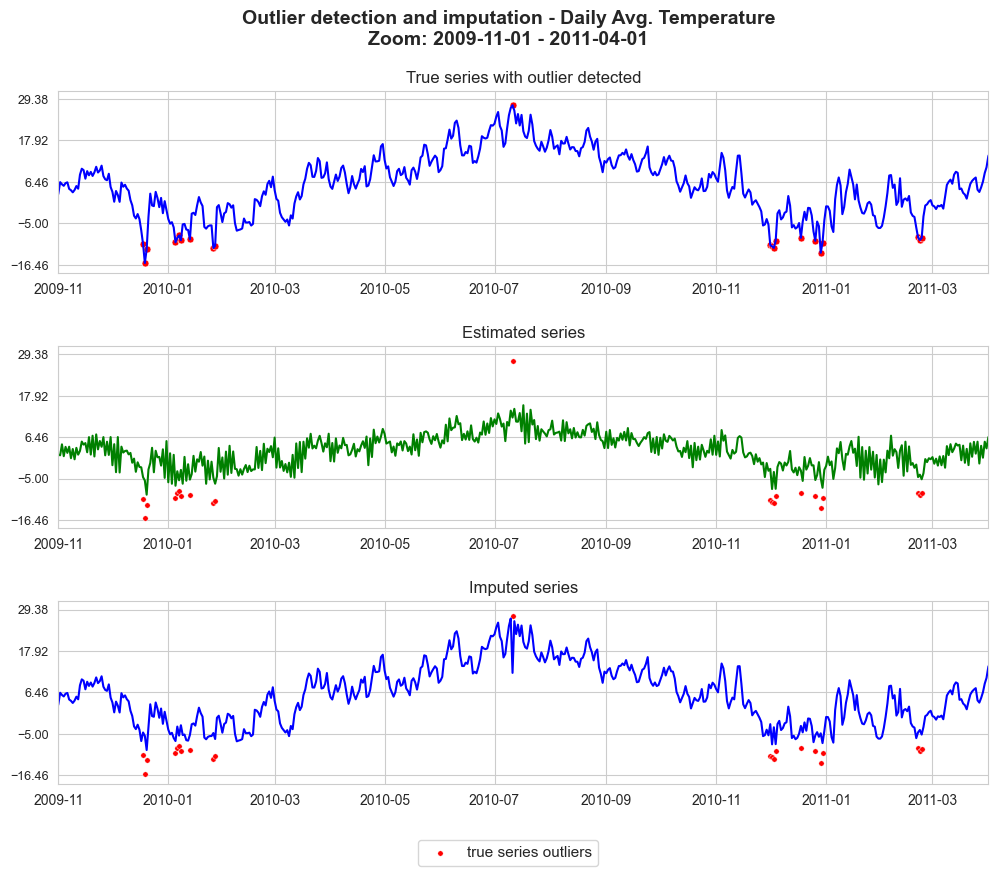

In [26]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='model', 
                                                           estimator=SARIMA(p=0, d=0, q=1, P=0, D=0, Q=0, s=0), h=1),
                          y=Y['T'], dates=df['T']['date'], X=X_st['T'],
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          zoom_start_date='2009-11-01', zoom_end_date='2011-04-01', title_height=0.97, legend_size=11)

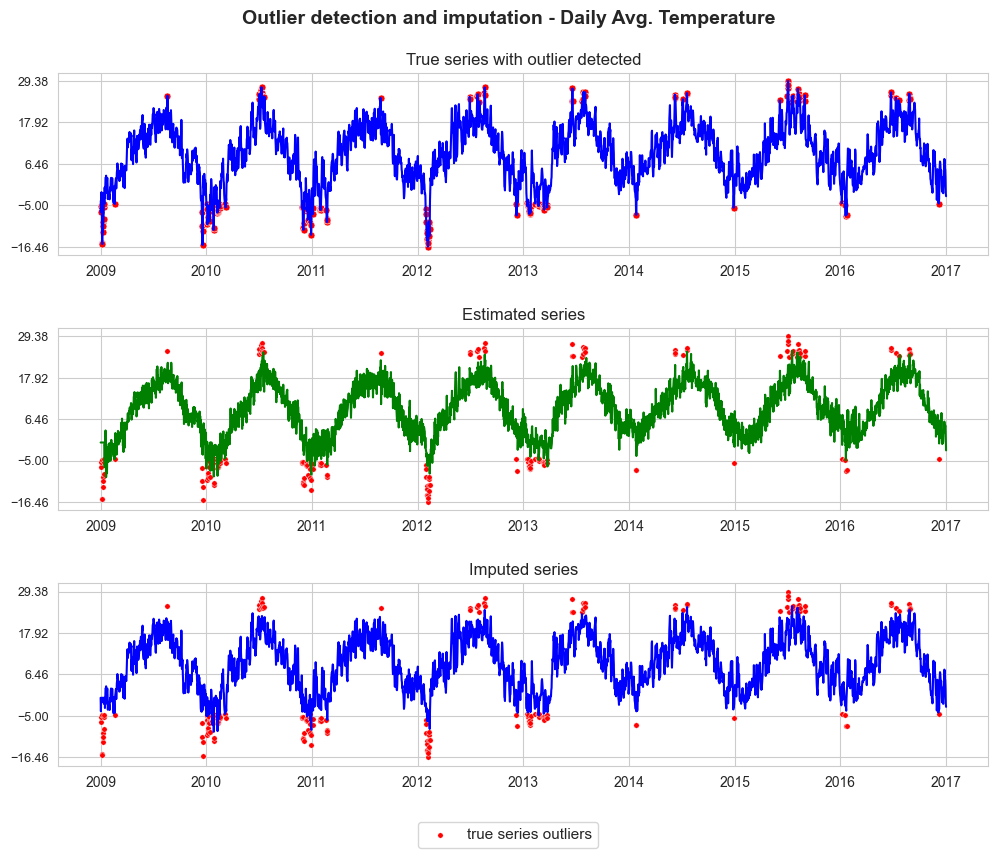

In [114]:
outliers_time_series_plot(figsize=(12,9), 
                          outliers_imputer=OutliersImputer(method='model', 
                                                           estimator=SARIMA(p=0, d=0, q=1, P=0, D=1, Q=1, s=14), h=0.70),
                          y=Y['T'], dates=df['T']['date'], X=X_st['T'],
                          title='Outlier detection and imputation - Daily Avg. Temperature',
                          titles_size=14, subtitles_size=12, hspace=0.4, bbox_to_anchor=(0.5,0.01),
                          legend_size=11)

## **Inner evaluation**

In [117]:
outer_test_window = 15
inner_test_window = 15
n_splits = 10

### **Defining the data**

In [118]:
# For Sklearn implementations
X_train_sk, X_test_sk, Y_train_sk, Y_test_sk = {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}, {col: {} for col in variables_forecasting}

# Train-Test split for univariate forecasting with Sklearn based implementations
for col in variables_forecasting:
    for lag in lags_grid:

        X_train_sk[col][lag], X_test_sk[col][lag], Y_train_sk[col][lag], Y_test_sk[col][lag] = train_test_split_time_series(X=X_sk[col][lag], 
                                                                                                                            y=Y_sk[col][lag], 
                                                                                                                            test_window=outer_test_window)

In [119]:
# For Statmodels implementations
X_train_st, X_test_st, Y_train_st, Y_test_st, = {}, {}, {}, {}

# Train-Test split for univariate forecasting with Statsmodels based implementations
for col in variables_forecasting:
    
    X_train_st[col], X_test_st[col], Y_train_st[col], Y_test_st[col] = train_test_split_time_series(X=X_st[col], y=Y[col], test_window=outer_test_window)

### **Defining outliers methods**

In [120]:
outliers_imputer = {'trend(h=1)': OutliersImputer(method='trend', period=7, h=1),
                    'trend(h=1.5)': OutliersImputer(method='trend', period=7, h=1.5),
                    'trend(h=0.75)': OutliersImputer(method='trend', period=7, h=0.75),
                    'SARIMA1(h=1)': OutliersImputer(method='model', h=1, estimator=SARIMA(p=0, d=0, q=1, P=0, D=0, Q=0, s=0)),
                    'ExpSmooth1(h=1)': OutliersImputer(method='model', h=1, estimator=SimpleExpSmooth(smoothing_level=0.05)),
                    'SARIMA1(h=1.5)': OutliersImputer(method='model', h=1.5, estimator=SARIMA(p=0, d=0, q=1, P=0, D=0, Q=0, s=0)),
                    'ExpSmooth1(h=1.5)': OutliersImputer(method='model', h=1.5, estimator=SimpleExpSmooth(smoothing_level=0.05)),
                    'ExpSmooth1(h=0.75)': OutliersImputer(method='model', h=0.75, estimator=SimpleExpSmooth(smoothing_level=0.05)),
                    'SARIMA1(h=0.80)': OutliersImputer(method='model', h=0.80, estimator=SARIMA(p=0, d=0, q=1, P=0, D=0, Q=0, s=0)),
                    'SARIMA2(h=0.70)': OutliersImputer(method='model', estimator=SARIMA(p=0, d=0, q=1, P=0, D=1, Q=1, s=14), h=0.70),
                    'SARIMA2(h=1)': OutliersImputer(method='model', estimator=SARIMA(p=0, d=0, q=1, P=0, D=1, Q=1, s=14), h=1),
                    'ExpSmooth2(h=1)': OutliersImputer(method='model', h=1, estimator=SimpleExpSmooth(smoothing_level=0.01)),
                    'ExpSmooth2(h=0.80)': OutliersImputer(method='model', h=0.80, estimator=SimpleExpSmooth(smoothing_level=0.01))
                    }

In [124]:
X_train_imputed_sk = {col: {lag: {} for lag in lags_grid} for col in variables_forecasting}

for col in variables_forecasting:
    for lag in lags_grid:
        for method in outliers_imputer.keys(): 
             
            outliers_imputer[method].fit(y=Y_train_st[col], X=X_train_st[col])
            Y_train_imputed = outliers_imputer[method].transform(y=Y_train_st['T'])

            make_lags = MakeLags(n_lags=lag, ascending=True)
            make_lags.fit()
            X_train_imputed_sk[col][lag][method] , _ = make_lags.transform(y=Y_train_imputed)

### **Applying inner evaluation to the top-5 models obtained in `PyTS` chapter**

In [ ]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_params', 'rb') as file:
        best_params = pickle.load(file)

In [ ]:
best_score = {}

In [ ]:
lag = 30
estimator = RandomForestRegressorTS(random_state=123).set_params(**best_params[f'RF(lag={lag})'])
series_name = 'T'

for method in outliers_imputer.keys():

    name = f'RF(lag={lag}, imputation={method})'

    best_score[name] = KFold_score_time_series(estimator=estimator, 
                                               X=X_train_imputed_sk[series_name][lag][method], 
                                               y=Y_train_sk[series_name][lag], 
                                               n_splits=n_splits, test_window=inner_test_window, 
                                               n_lags=lag, scoring=wape, framework='PyTS')

In [ ]:
lag = 40
estimator = ElasticNetTS(random_state=123).set_params(**best_params[f'ElasticNet(lag={lag})'])
series_name = 'T'

for method in outliers_imputer.keys():

    name = f'ElasticNet(lag={lag}, imputation={method})'

    best_score[name] = KFold_score_time_series(estimator=estimator, 
                                               X=X_train_imputed_sk[series_name][lag][method], 
                                               y=Y_train_sk[series_name][lag], 
                                               n_splits=n_splits, test_window=inner_test_window, 
                                               n_lags=lag, scoring=wape, framework='PyTS')

In [ ]:
lag = 30
estimator = DecisionTreeRegressorTS(random_state=123).set_params(**best_params[f'Trees(lag={lag})'])
series_name = 'T'

for method in outliers_imputer.keys():

    name = f'Trees(lag={lag}, imputation={method})'

    best_score[name] = KFold_score_time_series(estimator=estimator, 
                                               X=X_train_imputed_sk[series_name][lag][method], 
                                               y=Y_train_sk[series_name][lag], 
                                               n_splits=n_splits, test_window=inner_test_window, 
                                               n_lags=lag, scoring=wape, framework='PyTS')

In [ ]:
lag = 30
estimator = LinearSVRTS(random_state=123).set_params(**best_params[f'SVM(lag={lag})'])
series_name = 'T'

for method in outliers_imputer.keys():

    name = f'SVM(lag={lag}, imputation={method})'

    best_score[name] = KFold_score_time_series(estimator=estimator, 
                                               X=X_train_imputed_sk[series_name][lag][method], 
                                               y=Y_train_sk[series_name][lag], 
                                               n_splits=n_splits, test_window=inner_test_window, 
                                               n_lags=lag, scoring=wape, framework='PyTS')

In [ ]:
lag = 40
estimator = MLPRegressorTS(random_state=123).set_params(**best_params[f'MLP(lag={lag})'])
series_name = 'T'

for method in outliers_imputer.keys():

    name = f'MLP(lag={lag}, imputation={method})'

    best_score[name] = KFold_score_time_series(estimator=estimator, 
                                               X=X_train_imputed_sk[series_name][lag][method], 
                                               y=Y_train_sk[series_name][lag], 
                                               n_splits=n_splits, test_window=inner_test_window, 
                                               n_lags=lag, scoring=wape, framework='PyTS')

**Saving the results:**

In [132]:
'''
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_score_outlier_imputation', 'wb') as file:
    pickle.dump(best_score, file)
'''

**Opening the results:**

In [133]:
with open(r'C:\Users\fscielzo\Documents\DataScience-GitHub\Time Series\Temperature Prediction\Second Project\results\best_score_outlier_imputation', 'rb') as file:
        best_score = pickle.load(file)

### **Selecting the best model**

In [134]:
model_names = np.array(list(best_score.keys()))
inner_scores_values = np.array(list(best_score.values()))
best_model = model_names[np.argmin(inner_scores_values)]
score_best_model = np.min(inner_scores_values)

combined_models_score = list(zip(model_names, inner_scores_values))
sorted_combined_models_score= sorted(combined_models_score, key=lambda x: x[1], reverse=False)  # Sort from lower to greater
sorted_models, sorted_scores = zip(*sorted_combined_models_score)
sorted_models, sorted_scores = list(sorted_models), list(sorted_scores)

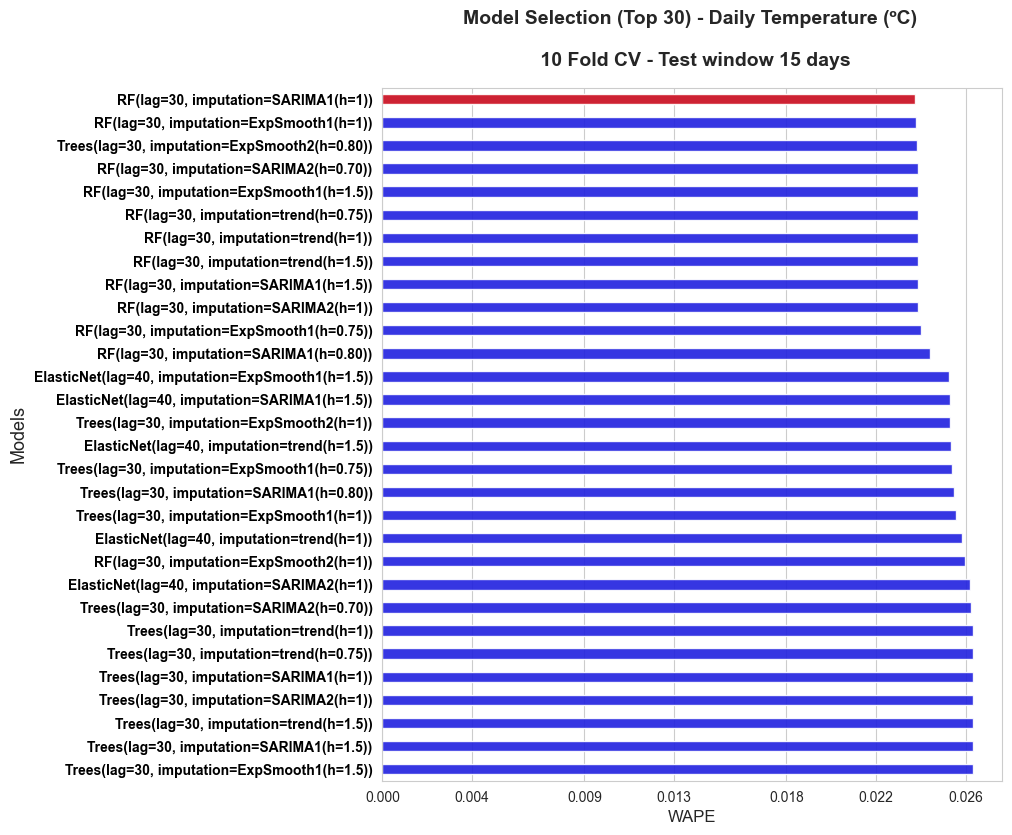

In [142]:
top = 30 

fig, axes = plt.subplots(figsize=(8,9))

ax = sns.barplot(y=sorted_models[0:top], x=sorted_scores[0:top], color='blue', width=0.45, alpha=0.9)
ax = sns.barplot(y=[best_model], x=[score_best_model], color='red', width=0.45, alpha=0.9)

ax.set_ylabel('Models', size=13)
ax.set_xlabel('WAPE', size=12)
ax.set_xticks(np.round(np.linspace(0, np.max(sorted_scores[0:top]), 7),3)) 
ax.tick_params(axis='y', labelsize=10)    
plt.title(f'Model Selection (Top {top}) - Daily Temperature (ºC) \n \n {n_splits} Fold CV - Test window {inner_test_window} days', size=14, weight='bold', y=1.02)

for label in ax.get_yticklabels():
        label.set_weight('bold')
        label.set_color('black') 

plt.show()